## Control Variables
- Resolution = 0.25
- ROBOT_RADIUS = 0.25
- NUM_OF_AGENT = 10
- BO_INITIAL_SAMPLES = 60
- BO_OPT_SAMPLES = 40

In [1]:
import BayesianOptimisation.boVoronoiDirected as boVoronoiDirected
import BayesianOptimisation.expGrid as expGrid
import BayesianOptimisation.expVoronoi as expVoronoi
import BayesianOptimisation.bo2VoronoiDirected as bo2VoronoiDirected
import BayesianOptimisation.experiment_setup as experiment
from core.DataStructure import *

from importlib import reload
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import copy

In [2]:
from scipy.optimize import minimize, Bounds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Reshape
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [3]:
np.random.seed(9)

In [4]:
reload(bo2VoronoiDirected)

<module 'BayesianOptimisation.bo2VoronoiDirected' from '/home/elim/Documents/Cambridge-Master/Research/code/BayesianOptimisation/bo2VoronoiDirected.py'>

### Generating Data

In [5]:
DATASET = 1

In [6]:
scene = "./input/random-32-32-10/scen-even/random-32-32-10-even-" + str(DATASET) + ".scen"
exp = experiment.Experiment(scene=scene)

In [7]:
import time
start = time.time()
opt, graph = bo2VoronoiDirected.bo2_voronoi_directed(exp)
end = time.time()
print(end - start)

Set Hyper Parameters, solving for 10 agents
total number of distance 440
Number of trainable probabilities 377
Length cutoff threshold 2
88.12338995933533


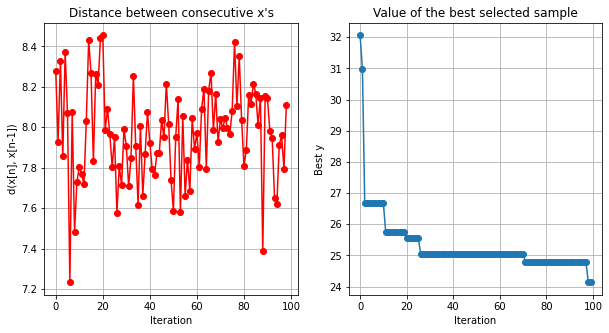

In [8]:
opt.plot_convergence()

In [9]:
pd.DataFrame(opt.x_opt).to_csv("./data/BO-100/results_100.csv", index=None)

In [10]:
probabilities = pd.read_csv("./data/BO-100/results_100.csv")
probabilities = probabilities.to_numpy()
probabilities = probabilities.reshape((-1))
scene = "./input/random-32-32-10/scen-even/random-32-32-10-even-" + str(DATASET) + ".scen"
exp = experiment.Experiment(scene=scene)

In [11]:
def getCoverage(exp, G, directed = False):
    total_area = 0
    total_dist = 0
    assigned = {}
    fig, ax = plt.subplots(figsize=(6,6))
    plt.xlim(0,34)
    plt.ylim(0,34)
    count = 0
    for n in G.nodes:
        for e in G.neighbors(n):
            if n != e and frozenset((n, e)) not in assigned.keys():
                
                p1 = G.nodes[n]['position']
                p2 = G.nodes[e]['position']
                
                if (directed):
                    d = G.edges[n,e,0]['distance']
                    c = G.edges[n,e,0]['capacity']
                else:
                    d = G.edges[n,e]['distance']
                    c = G.edges[n,e]['capacity']
                
                
                assigned[frozenset((n, e))] = 1

                adjustp1 = Point(p1.y, p1.x)
                adjustp2 = Point(p2.y, p2.x)

                refpt1 = adjustp1 if adjustp1.y <= adjustp2.y else adjustp2
                refpt2 = adjustp1 if adjustp1.y > adjustp2.y else adjustp2

                if refpt1.x >= refpt2.x:
                    theta_rot = np.pi - np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))
                else:
                    theta_rot = np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))

                if theta_rot >= np.pi/2:
                    theta = theta_rot - np.pi/2
                else:
                    theta = theta_rot + np.pi/2

                dy = -(c/2)*np.sin(theta)
                if refpt1.y == refpt2.y:
                    dx = 0
                    width = d
                    height = c
                    a = 0
                elif refpt1.x > refpt2.x:
                    dx = -(c/2)*np.cos(theta)
                    width = c
                    height = d
                    a = (theta) * 180 / np.pi
                elif refpt1.x == refpt2.x:
                    dx = -(c/2)
                    width = c
                    height = d
                    a = 0
                else:
                    dx = (c/2)*np.cos(np.pi - theta)
                    width = d
                    height = c
                    a = (theta_rot) * 180 / np.pi
                    

                rect = Rectangle((refpt1.x+dx,refpt1.y+dy),width,height,linewidth=0.1,fill=True, angle = a,color = 'black')
                plt.gca().add_patch(rect)
                count +=1

    for o in exp.obstacles_loc:
        adjustedx, adjustedy = o[1],o[0]
        rect = Rectangle((adjustedx-0.5,adjustedy-0.5),1,1,linewidth=0.1,fill=True, angle = 0, color = 'black')
        plt.gca().add_patch(rect)

    ax.axis('off')

    im = fig
    im.canvas.draw()
    X = np.array(im.canvas.renderer._renderer)
    X_reshape = X.reshape((-1,4))
    X_reshape = np.delete(X_reshape, [1,2,3], axis = 1)
    black = np.count_nonzero(X_reshape == 0)
    white= np.count_nonzero(X_reshape == 255)
    print("Black px", black, "White px", white)
    percentage = black/(white+black)
    return percentage

Set Hyper Parameters, solving for 10 agents
total number of distance 440
Number of trainable probabilities 377
Length cutoff threshold 2
Black px 106434 White px 80190
time 9.15119743347168


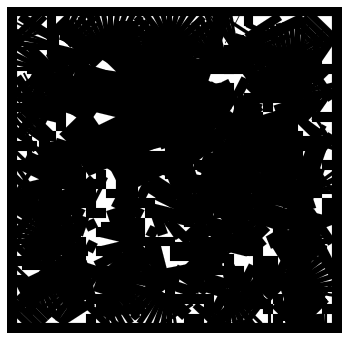

In [12]:
import time
start = time.time()

output = bo2VoronoiDirected.get_results(probabilities, exp)
vordir_paths, vordir_cost, vordir_ft, vordir_u1, vordir_u2, vordir_con, vordir_conmax, vordir_conavg, vordir_G0, vordir_G, vordir_thres = output
vordir_u2 = getCoverage(exp,vordir_G, directed = True)

end = time.time()
print("time", end - start)

In [13]:
results = [vordir_cost, vordir_ft, vordir_u1, vordir_u2, vordir_conmax, vordir_conavg, vordir_thres]
pd.DataFrame([results],columns=['cost','vordir_ft','vordir_u1','vordir_u2','vordir_max', 'vordir_avg','subgraph'])

,cost,vordir_ft,vordir_u1,vordir_u2,vordir_max,vordir_avg,subgraph
0,24.133348,20.953973,0.313527,0.570312,3.0,0.625,0.015503


### Visualisation

In [44]:
def showAccSolution(result_graph, paths, image, nodes, start_nodes, end_nodes, all_path = True, path_num = 0):
    edges_in_path = []
    image2 = 1-image
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-image)
    ax = sb.heatmap(img)
    assigned = {}
    
    for index, path in enumerate(paths):
#         path = paths[path_num]
        for ite in range(len(path)-1):
            edges_in_path.append(np.array([path[ite],path[ite+1],0]))
            p1 = result_graph.nodes[path[ite]]['position']
            p2 = result_graph.nodes[path[ite+1]]['position']

            for r in (p1.x, p2.x, 1):
                for c in (p1.y, p2.y, 1):
                    if (Point(r,c) in np.array(nodes)[end_nodes]):
                        image2[int(r),int(c)] = 1
                    else:
                        image2[int(r),int(c)] += 0.2

        drawn = {}
        loop = result_graph.edges if all_path else edges_in_path

        for elem in loop:
            cur = result_graph.edges[elem[0], elem[1], 0]['probability']
            opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
            unused = 1 - cur - opposite
            scaler = 0.7
            if cur > opposite:
                p1 = result_graph.nodes[elem[0]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[1]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            else:
                p1 = result_graph.nodes[elem[1]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[0]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            
            # only draw arrow once
            if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys():
                plt.arrow(p1.y, p1.x, dy, dx, head_width = 0.35, alpha=0.9, color = 'grey', linewidth=1)
                assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
            
#         p = start_nodes[index]
#         plt.scatter(nodes[p].y, nodes[p].x, color = 'red', linewidths=5)
#         p = end_nodes[index]
#         plt.scatter(nodes[p].y, nodes[p].x, color = 'lime', linewidths=5)
#         name = './results/vordir_path'+ str(path_num)+'.png'
#         plt.gca().invert_yaxis()
#         plt.savefig(name)
        
    for p in start_nodes:
        plt.scatter(nodes[p].y, nodes[p].x, color = 'red', linewidths=5)
    for p in end_nodes:
        plt.scatter(nodes[p].y, nodes[p].x, color = 'lime', linewidths=5)

#     name = './data/'+ 'ANN' +'.png'
    plt.gca().invert_yaxis()
#     plt.savefig(name)
    return fig

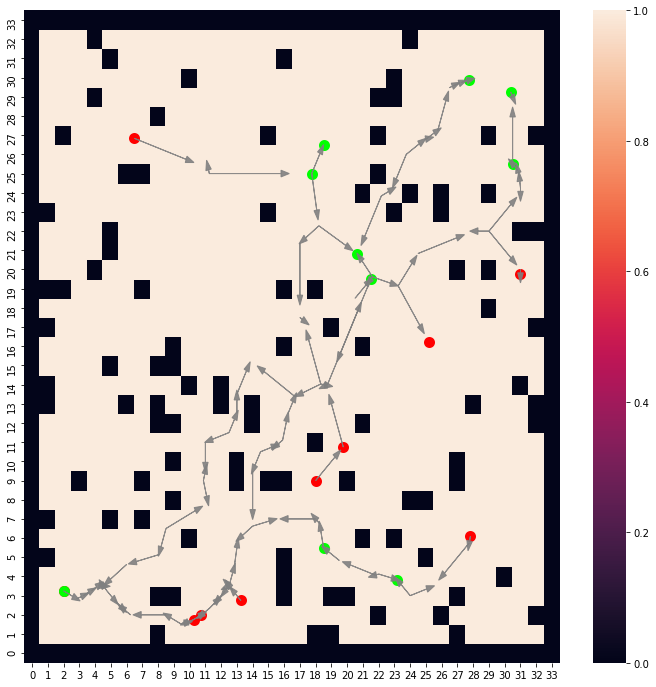

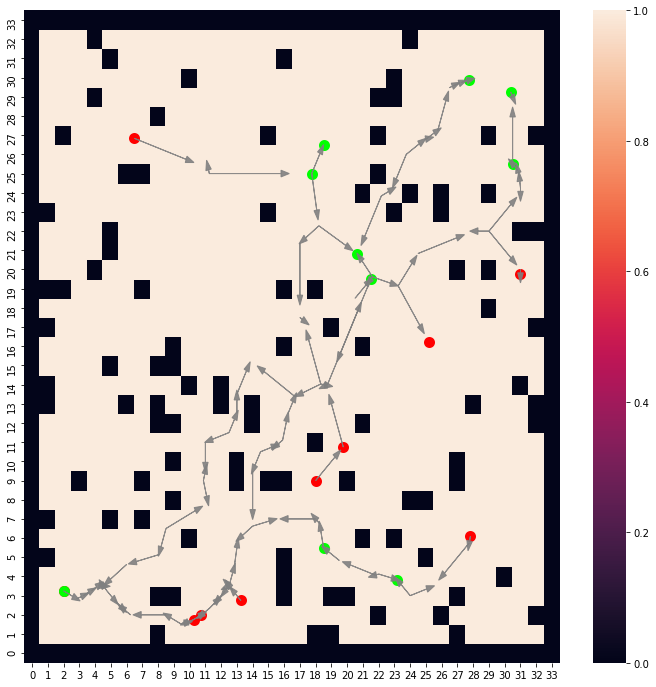

In [45]:
showAccSolution(vordir_G0, 
                vordir_paths, 
                exp.image, 
                exp.nodes, 
                exp.start_nodes, 
                exp.end_nodes, 
                all_path = False, 
                path_num = 0) #path_num variables is unused

In [18]:
# from scipy.optimize import minimize, rosen, rosen_der
# x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
# res = minimize(rosen, x0, method='Nelder-Mead', tol=1e-6)
# res.x

In [ ]:
# import numpy as np
# from sklearn.linear_model import SGDRegressor
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# n_samples, n_features = 10, 5
# rng = np.random.RandomState(0)
# y = rng.randn(n_samples)
# X = rng.randn(n_samples, n_features)
# # Always scale the input. The most convenient way is to use a pipeline.
# reg = make_pipeline(StandardScaler(),
#                     SGDRegressor(max_iter=1000, tol=1e-3))
# reg.fit(X, y)

In [ ]:
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.compose import TransformedTargetRegressor
# tt = TransformedTargetRegressor(regressor=SGDRegressor(max_iter=1000, tol=1e-3),
#                                 func=np.log, inverse_func=np.exp)
# X = np.arange(4).reshape(-1, 1)
# y = np.exp(2 * X).ravel()
# tt.fit(X, y)

# tt.score(X, y)

# tt.regressor_.coef_